In [1]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from torch.utils.data import random_split
from sklearn.model_selection import KFold
from torch import nn, optim
from augraphy import AugraphyPipeline

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [4]:
class MixUp:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def mixup_data(self, x, y):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = x.size()[0]
        index = torch.randperm(batch_size)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def mixup_loss(self, loss_fn, pred, labels_a, labels_b, lam):
        return lam * loss_fn(pred, labels_a) + (1 - lam) * loss_fn(pred, labels_b)

In [5]:
import numpy as np
import torch
import random

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)

    # Randomly select the bounding box for CutMix
    width, height = x.size()[2], x.size()[3]
    cut_ratio = np.sqrt(1. - lam)
    cut_width = int(width * cut_ratio)
    cut_height = int(height * cut_ratio)

    # Randomly select the position of the bounding box
    cx = np.random.randint(width)
    cy = np.random.randint(height)

    # Ensure bounding box coordinates are within image dimensions
    bb_x1 = np.clip(cx - cut_width // 2, 0, width)
    bb_x2 = np.clip(cx + cut_width // 2, 0, width)
    bb_y1 = np.clip(cy - cut_height // 2, 0, height)
    bb_y2 = np.clip(cy + cut_height // 2, 0, height)

    # Create the CutMix images
    mixed_x = x.clone()
    mixed_x[:, :, bb_y1:bb_y2, bb_x1:bb_x2] = x[index, :, bb_y1:bb_y2, bb_x1:bb_x2]

    # Return mixed images and corresponding labels
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_loss(loss_fn, pred, labels_a, labels_b, lam):
    return lam * loss_fn(pred, labels_a) + (1 - lam) * loss_fn(pred, labels_b)

In [6]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

def train_one_epoch(loader, model, optimizer, loss_fn, device, epoch, mixup=None, cutmix=False):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Ensure targets is a tensor
        if isinstance(targets, int):
            targets = torch.tensor(targets)
    
        targets = targets.to(device)

        # Reset gradients
        optimizer.zero_grad(set_to_none=True)

        # Determine if MixUp or CutMix should be applied
        if epoch == 2 and mixup is not None:  # Apply MixUp in the third epoch (index 2)
            mixed_image, targets_a, targets_b, lam = mixup.mixup_data(image, targets)
            preds = model(mixed_image)
            loss = mixup.mixup_loss(loss_fn, preds, targets_a, targets_b, lam)
        
        elif cutmix:  # Apply CutMix if it's enabled
            mixed_image, targets_a, targets_b, lam = cutmix_data(image, targets)
            preds = model(mixed_image)
            loss = cutmix_loss(loss_fn, preds, targets_a, targets_b, lam)
        
        else:  # Regular training for other epochs
            preds = model(image)
            loss = loss_fn(preds, targets)

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    # Calculate average loss and metrics
    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [ ]:
df = pd.read_csv('/root/CV_PJT/CV_PJT/code/train4.csv')
sample_submission_df = pd.read_csv("/root/CV_PJT/CV_PJT/data/data/sample_submission.csv")

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [8]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
# data_path = 'datasets_fin/'
train_img_path = '/root/CV_PJT/CV_PJT/data/data/train'
test_img_path = '/root/CV_PJT/CV_PJT/data/data/test'
train_path = '/root/CV_PJT/CV_PJT/code/train2_3_7(14).csv'
sub_path = '/root/CV_PJT/CV_PJT/data/data/sample_submission.csv'

# model config
model_name = 'efficientnet_b3'

# training config
img_size = 224
LR = 1e-4
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0
log_interval = 100

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2
from augraphy import *
from augraphy.base.augmentationsequence import AugmentationSequence
from augraphy.augmentations import *

import torch
from torch.optim.lr_scheduler import StepLR

In [11]:
from augraphy import AugmentationSequence, InkBleed, ColorPaper, Markup, Scribbles, BleedThrough

In [12]:
# Define AugraphyTransform as before
class AugraphyTransform(ImageOnlyTransform):
    def __init__(self, p=0.7, always_apply=False):
        super(AugraphyTransform, self).__init__(p=p, always_apply=always_apply)
        # Define the Augraphy pipeline with desired augmentations
        self.pipeline = AugmentationSequence([
            # Ink bleed effect
            InkBleed(intensity_range=(0.1, 0.2), kernel_size=(3, 5), severity=(0.4, 0.6), p=0.5),
            # Paper color changes
            ColorPaper(hue_range=(-10, 10), saturation_range=(-30, 30), p=0.5),
            # Markup
            Markup(num_lines_range=(2, 5), p=0.5),
            # Scribbles
            Scribbles(scribbles_type="random", scribbles_ink="random", scribbles_location="random",
                      scribbles_size_range=(250, 600), scribbles_count_range=(1, 6), p=0.5),
            # BleedThrough effect
            BleedThrough(intensity_range=(0.1, 0.2), offsets=(10, 20), p=0.5),
        ])

    def apply(self, img, **params):
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        augmented_image = self.pipeline(img)[0]
        return augmented_image

In [13]:
# Define transformations with and without AugraphyTransform
def get_transform(with_augraphy=True):
    transforms = [
        A.Resize(height=img_size, width=img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
    if with_augraphy:
        transforms.insert(4, AugraphyTransform(p=0.7))  # Insert AugraphyTransform before normalization
    return A.Compose(transforms)

In [14]:
# Initial transformations with AugraphyTransform
trn_transform = get_transform(with_augraphy=True)
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [15]:
# Dataset definition
full_dataset = ImageDataset(
    train_path,
    train_img_path,
    transform=trn_transform
)

# Calculate the total number of samples in the dataset
dataset_size = len(full_dataset)

# Define the ratios for training and validation
train_ratio = 0.8  # Use 80% of the data for training
val_ratio = 1 - train_ratio  # Remaining 20% for validation

# Calculate the number of samples for training and validation
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size  # Ensure all samples are accounted for

# Split the dataset into training and validation sets
trn_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Define the test dataset
tst_dataset = ImageDataset(
    sub_path,
    test_img_path,
    transform=tst_transform
)

# Print the sizes of the datasets
print("Training dataset size:", len(trn_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(tst_dataset))

Training dataset size: 14080
Validation dataset size: 3520
Test dataset size: 3140


In [16]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [17]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

criterion = LabelSmoothingLoss(classes=17, smoothing=0.1)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # e.g., reduce LR by a factor every 5 epochs
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scheduler.step(0)  # Apply the initial learning rate adjustment if needed

In [ ]:
# # Continue your training loop from start_epoch to EPOCHS
# for epoch in range(EPOCHS):
#     if epoch == 0:
#         trn_dataset.transform = get_transform(with_augraphy=True)
        
#     # 데이터셋 epoch 업데이트
#         trn_dataset.epoch = epoch
        
#         # 세 번째 에포크부터는 데이터의 30%만 사용
#     if epoch >= 3:
#         indices = list(range(len(trn_dataset)))
#         random.shuffle(indices)
#         subset_size = int(0.5 * len(trn_dataset))
#         subset_indices = indices[:subset_size]
#         current_dataset = Subset(trn_dataset, subset_indices)
#     else:
#         current_dataset = trn_dataset
            
#     trn_loader = DataLoader(
#         current_dataset, 
#         batch_size=BATCH_SIZE, 
#         shuffle=True,
#         num_workers=0,
#         pin_memory=True
#     )

#     # Determine if MixUp or CutMix should be applied
#     if epoch == 1:
#         # Create a subset of 30% for MixUp
#         indices = list(range(len(current_dataset)))
#         random.shuffle(indices)
#         subset_size = int(0.3 * len(current_dataset))  # 30% of current dataset
#         subset_indices = indices[:subset_size]
#         current_subset = Subset(current_dataset, subset_indices)
#         ret = train_one_epoch(current_subset, model, optimizer, loss_fn, device, epoch, mixup=MixUp)
                              
#     elif epoch == 2:
#         # Create a subset of 30% for CutMix
#         indices = list(range(len(current_dataset)))
#         random.shuffle(indices)
#         subset_size = int(0.3 * len(current_dataset))  # 30% of current dataset
#         subset_indices = indices[:subset_size]
#         current_subset = Subset(current_dataset, subset_indices)
#         ret = train_one_epoch(current_subset, model, optimizer, loss_fn, device, epoch, cutmix=True)
        
#     else:
#         ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch)


#         # 결과 로깅
#         log = f"Epoch: {epoch}\n"
#         for k, v in ret.items():
#             log += f"{k}: {v:.4f}\n"
#         print(log)

#         scheduler.step()

  0%|          | 0/440 [00:00<?, ?it/s]


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3>; VDepth = cv::impl::{anonymous}::Set<0, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 224


In [ ]:
# import os
# import torch

# # Define the path to your saved model checkpoint
# folder_path = "/root/CV_PJT/CV_PJT/model"
# model_save_path = os.path.join(folder_path, "entire_model_resnext_(1).pth")

# # Check if the checkpoint file exists
# if os.path.exists(model_save_path):
#     # Load the saved model checkpoint
#     checkpoint = torch.load(model_save_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

#     # Load the model state
#     model.load_state_dict(checkpoint['model_state_dict'])

#     # Load the optimizer state
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#     # Load the starting epoch for resuming
#     start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
#     print(f"Resuming training from epoch {start_epoch}...")
# else:
#     print("No checkpoint found. Starting training from scratch.")
#     start_epoch = 1  # Start from the first epoch if no checkpoint exists


Resuming training from epoch 2...


In [ ]:

# Define the total number of epochs you want to run
EPOCHS = 100  # Adjust this as necessary for your training

# Continue your training loop from start_epoch to EPOCHS
for epoch in range(start_epoch, EPOCHS):
    # Change the training transform if needed
    if epoch == 1:
        trn_dataset.transform = get_transform(with_augraphy=False)

    # Determine if MixUp or CutMix should be applied
    if epoch == 1:
        ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch, mixup=MixUp)
    elif epoch == 2:
        ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch, cutmix=True)
    else:
        ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch)

    # Log the results
    log = f"Epoch: {epoch}\n"
    for k, v in ret.items():
        log += f"{k}: {v:.4f}\n"
    print(log)

    # Step the scheduler
    scheduler.step()

    # Save the checkpoint at the end of the epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, model_save_path)


Loss: 1.2774: 100%|██████████| 9226/9226 [2:29:29<00:00,  1.03it/s]  


Epoch: 2
train_loss: 1.0458
train_acc: 0.5371
train_f1: 0.5355



Loss: 0.0161: 100%|██████████| 9226/9226 [2:30:26<00:00,  1.02it/s]  


Epoch: 3
train_loss: 0.0761
train_acc: 0.9737
train_f1: 0.9737



Loss: 0.1401: 100%|██████████| 9226/9226 [2:27:53<00:00,  1.04it/s]  


Epoch: 4
train_loss: 0.0537
train_acc: 0.9815
train_f1: 0.9815



Loss: 0.0537: 100%|██████████| 9226/9226 [2:30:21<00:00,  1.02it/s]  


Epoch: 5
train_loss: 0.0416
train_acc: 0.9857
train_f1: 0.9857



Loss: 0.0030: 100%|██████████| 9226/9226 [2:29:42<00:00,  1.03it/s]  


Epoch: 6
train_loss: 0.0234
train_acc: 0.9920
train_f1: 0.9920



Loss: 0.0132:   7%|▋         | 619/9226 [10:17<2:23:01,  1.00it/s]


KeyboardInterrupt: 

In [ ]:
import torch

# Define the path where you saved the model
# Define folder and filename
folder_path = "/root/CV_PJT/CV_PJT/model"
os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist
model_save_path  = os.path.join(folder_path, "entire_model_resnext.pth")

# At the end of your training loop
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # Add any other information you want to save, like loss or metrics
}, model_save_path)

In [ ]:
import os
import torch

# Define the path to your saved model checkpoint
folder_path = "/root/CV_PJT/CV_PJT/model"
model_save_path = os.path.join(folder_path, "entire_model_resnext_(2).pth")

# Check if the checkpoint file exists
if os.path.exists(model_save_path):
    # Load the saved model checkpoint
    checkpoint = torch.load(model_save_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Load the model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load the optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load the starting epoch for resuming
    start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
    print(f"Resuming training from epoch {start_epoch}...")
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 1  # Start from the first epoch if no checkpoint exists


Resuming training from epoch 8...


In [ ]:
# Continue your training loop from start_epoch to EPOCHS
for epoch in range(start_epoch, EPOCHS):
    if epoch == 0:
        trn_dataset.transform = get_transform(with_augraphy=True)
        
    # 데이터셋 epoch 업데이트
        trn_dataset.epoch = epoch
        
        # 세 번째 에포크부터는 데이터의 30%만 사용
    if epoch >= 3:
        indices = list(range(len(trn_dataset)))
        random.shuffle(indices)
        subset_size = int(0.5 * len(trn_dataset))
        subset_indices = indices[:subset_size]
        current_dataset = Subset(trn_dataset, subset_indices)
    else:
        current_dataset = trn_dataset
            
    trn_loader = DataLoader(
        current_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    # Determine if MixUp or CutMix should be applied
    if epoch == 1:
        # Create a subset of 30% for MixUp
        indices = list(range(len(current_dataset)))
        random.shuffle(indices)
        subset_size = int(0.3 * len(current_dataset))  # 30% of current dataset
        subset_indices = indices[:subset_size]
        current_subset = Subset(current_dataset, subset_indices)
        ret = train_one_epoch(current_subset, model, optimizer, loss_fn, device, epoch, mixup=MixUp)
                              
    elif epoch == 2:
        # Create a subset of 30% for CutMix
        indices = list(range(len(current_dataset)))
        random.shuffle(indices)
        subset_size = int(0.3 * len(current_dataset))  # 30% of current dataset
        subset_indices = indices[:subset_size]
        current_subset = Subset(current_dataset, subset_indices)
        ret = train_one_epoch(current_subset, model, optimizer, loss_fn, device, epoch, cutmix=True)
        
    else:
        ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch)


        # 결과 로깅
        log = f"Epoch: {epoch}\n"
        for k, v in ret.items():
            log += f"{k}: {v:.4f}\n"
        print(log)

        scheduler.step()

Loss: 0.0003: 100%|██████████| 4613/4613 [1:16:32<00:00,  1.00it/s]


Epoch: 8
train_loss: 0.0182
train_acc: 0.9939
train_f1: 0.9939



Loss: 0.0006:   0%|          | 4/4613 [00:04<1:33:44,  1.22s/it]


KeyboardInterrupt: 

In [ ]:
import torch

# Define the path where you saved the model
# Define folder and filename
folder_path = "/root/CV_PJT/CV_PJT/model"
os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist
model_save_path  = os.path.join(folder_path, "entire_model_resnext_(3).pth")

# At the end of your training loop
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # Add any other information you want to save, like loss or metrics
}, model_save_path)

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [ ]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:16<00:00,  6.08it/s]


In [ ]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [ ]:
sample_submission_df = pd.read_csv("/root/CV_PJT/CV_PJT/data/data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [ ]:
pred_df.to_csv("pred_22.csv", index=False)

In [ ]:
len(pred_df)

3140

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_273216/3309000382.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=pred_df, palette='Set2')


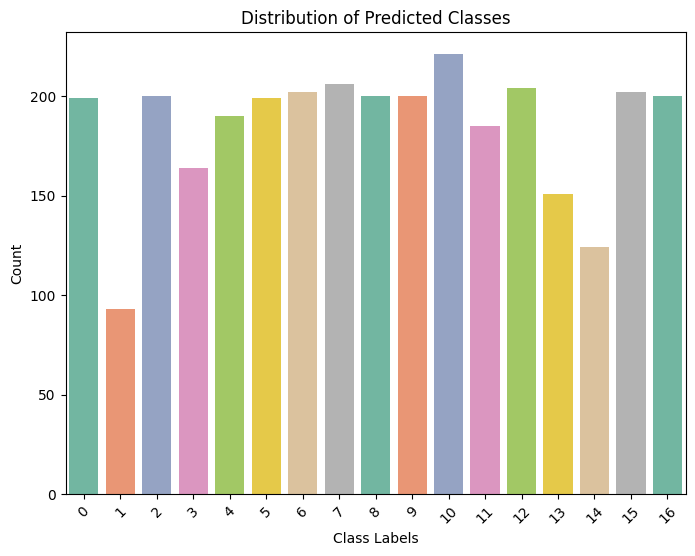

In [ ]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Count the number of predictions per class
sns.countplot(x='target', data=pred_df, palette='Set2')
plt.title('Distribution of Predicted Classes')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()